# PRZYGOTOWANIE ZBIORU DANYCH

In [1]:
#biblioteki do przygotowania zbioru
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk
#
from textblob import TextBlob

import numpy as np

In [2]:
#POBIERANIE SPECYFIKI J. ANGIELSKIEGO W CELU ANALIZY
#POBRANIE SŁÓW ZE STOP LISTY
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

#pobierz Punkt Tokenizer Models
nltk.download('punkt')

#POBRANIE ANGIELSKIEJ BAZY DANYCH: rzeczowników, czasowników, przymiotników, przysłówków i zaimków
from textblob import Word
nltk.download('wordnet')

#POBRANIE Greedy Averaged Perceptron tagger
nltk.download('averaged_perceptron_tagger')
### ŁADOWANIE GŁÓWNEGO ZBIORU DO NAUKI

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mkijewski\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mkijewski\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mkijewski\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mkijewski\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### ŁADOWANIE GŁÓWNEGO ZBIORU DO NAUKI


In [3]:
trainSet = pd.read_csv("corona.csv",encoding='latin1')
testSet = pd.read_csv("corona-test.csv",encoding='latin1')

mainSet = pd.concat([trainSet,testSet])
mainSet

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


### ZWĘŻENIE OPINII W ZBIORZE 


In [4]:
# Uproszczenie danych w celu łatwiejszej analizy

mainSet["Sentiment"] = mainSet["Sentiment"].astype(str)
def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
mainSet['Sentiment']=mainSet['Sentiment'].apply(lambda x:classes_def(x))
mainSet

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,negative


In [5]:
mainSet['text']=mainSet.OriginalTweet
mainSet['text']=mainSet['text'].astype(str)

sentiment = mainSet.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
sentiment=sentiment.set_index('Sentiment')
sentiment

,text
Sentiment,
positive,19592
negative,17031
neutral,8332


<AxesSubplot:xlabel='Sentiment'>

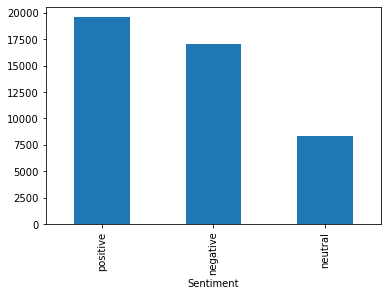

In [6]:
sentiment.plot(kind="bar", legend=None)

In [7]:
#wyświetl 100 rekordów

print(mainSet.head(100))
print(mainSet.describe())

    UserName  ScreenName                    Location     TweetAt  \
0       3799       48751                      London  16-03-2020   
1       3800       48752                          UK  16-03-2020   
2       3801       48753                   Vagabonds  16-03-2020   
3       3802       48754                         NaN  16-03-2020   
4       3803       48755                         NaN  16-03-2020   
..       ...         ...                         ...         ...   
95      3894       48846  FREE goal setting guide ??  16-03-2020   
96      3895       48847              Washington, DC  16-03-2020   
97      3896       48848              Washington, DC  16-03-2020   
98      3897       48849       San Joaquin Valley CA  16-03-2020   
99      3898       48850                Planet Earth  16-03-2020   

                                        OriginalTweet Sentiment  \
0   @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   neutral   
1   advice Talk to your neighbours family to exch

# ANALIZY ZBIORU

In [8]:
mainSet['word_count']= mainSet['OriginalTweet'].apply(lambda x: len(str(x).split(" ")))
mainSet[['OriginalTweet', 'word_count']].head(10)

,OriginalTweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,40
4,"Me, ready to go at supermarket during the #COV...",38
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,12
8,Due to COVID-19 our retail store and classroom...,46
9,"For corona prevention,we should stop to buy th...",42


#### średnia długość słowa

In [9]:
def avgWord(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))


mainSet['avg_words'] = mainSet['OriginalTweet'].apply(lambda x:avgWord(x))
mainSet[['OriginalTweet', 'avg_words']].head(10)

,OriginalTweet,avg_words
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,13.000000
1,advice Talk to your neighbours family to excha...,5.263158
2,Coronavirus Australia: Woolworths to give elde...,8.428571
3,My food stock is not the only one which is emp...,6.000000
4,"Me, ready to go at supermarket during the #COV...",6.525000
5,As news of the regionÂs first confirmed COVID...,5.972222
6,Cashier at grocery store was sharing his insig...,5.464286
7,Was at the supermarket today. Didn't buy toile...,7.846154
8,Due to COVID-19 our retail store and classroom...,5.222222
9,"For corona prevention,we should stop to buy th...",5.380952


### ilość znaków tweeta

In [10]:
mainSet['char_count']=mainSet['OriginalTweet'].str.len()
mainSet[['OriginalTweet', 'char_count']].head(10)

,OriginalTweet,char_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,111
1,advice Talk to your neighbours family to excha...,237
2,Coronavirus Australia: Woolworths to give elde...,131
3,My food stock is not the only one which is emp...,306
4,"Me, ready to go at supermarket during the #COV...",310
5,As news of the regionÂs first confirmed COVID...,250
6,Cashier at grocery store was sharing his insig...,180
7,Was at the supermarket today. Didn't buy toile...,119
8,Due to COVID-19 our retail store and classroom...,280
9,"For corona prevention,we should stop to buy th...",267


### słowa ze stoplisty

In [11]:
mainSet['stopwords']=mainSet['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
mainSet[['OriginalTweet', 'stopwords']].head(10)

,OriginalTweet,stopwords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,11
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,14
4,"Me, ready to go at supermarket during the #COV...",13
5,As news of the regionÂs first confirmed COVID...,8
6,Cashier at grocery store was sharing his insig...,9
7,Was at the supermarket today. Didn't buy toile...,2
8,Due to COVID-19 our retail store and classroom...,18
9,"For corona prevention,we should stop to buy th...",16


### ZNAKI SPECJALNE W TWEET'CIE

In [12]:
specialPatt=r"[^a-zA-Z0-9 ]"
mainSet['special_characters']=mainSet['OriginalTweet'].str.findall(specialPatt)
mainSet['special_characters']=mainSet['special_characters'].apply(lambda x: len(x))
mainSet[['OriginalTweet', 'special_characters']].head(10)
mainSet

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,word_count,avg_words,char_count,stopwords,special_characters
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8,13.000000,111,2,19
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive,advice Talk to your neighbours family to excha...,38,5.263158,237,11,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive,Coronavirus Australia: Woolworths to give elde...,14,8.428571,131,1,8
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive,My food stock is not the only one which is emp...,40,6.000000,306,14,37
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative,"Me, ready to go at supermarket during the #COV...",38,6.525000,310,13,35
...,...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive,Meanwhile In A Supermarket in Israel -- People...,18,6.111111,127,3,10
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative,Did you panic buy a lot of non-perishable item...,34,5.294118,213,13,12
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral,Asst Prof of Economics @cconces was on @NBCPhi...,26,6.153846,185,11,13
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,negative,Gov need to do somethings instead of biar je r...,29,5.034483,174,4,7


### ILOŚĆ SŁÓW Z WIELKIEJ LITERY W TWEET'CIE

In [13]:
mainSet['numerics'] = mainSet['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
mainSet[['OriginalTweet', 'numerics']].head(10)

,OriginalTweet,numerics
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",0
5,As news of the regionÂs first confirmed COVID...,0
6,Cashier at grocery store was sharing his insig...,0
7,Was at the supermarket today. Didn't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,0
9,"For corona prevention,we should stop to buy th...",0


In [14]:
mainSet.corr()

,UserName,ScreenName,word_count,avg_words,char_count,stopwords,special_characters,numerics
UserName,1.000000,1.000000,-0.077938,0.044671,-0.048285,-0.093281,-0.027700,0.060658
ScreenName,1.000000,1.000000,-0.077938,0.044671,-0.048285,-0.093281,-0.027700,0.060658
word_count,-0.077938,-0.077938,1.000000,-0.354407,0.853798,0.847810,0.096506,0.172068
avg_words,0.044671,0.044671,-0.354407,1.000000,-0.054861,-0.420707,0.301650,-0.159020
char_count,-0.048285,-0.048285,0.853798,-0.054861,1.000000,0.601460,0.472355,0.038452
stopwords,-0.093281,-0.093281,0.847810,-0.420707,0.601460,1.000000,-0.121965,0.090218
special_characters,-0.027700,-0.027700,0.096506,0.301650,0.472355,-0.121965,1.000000,-0.160979
numerics,0.060658,0.060658,0.172068,-0.159020,0.038452,0.090218,-0.160979,1.000000


# NORMALIZACJA ZBIORU

In [15]:
# oryginalna kopia zbioru
mainSetDFRaw = mainSet.copy()


In [16]:
mainSet['OriginalTweet'] = mainSet['OriginalTweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
mainSet['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today. didn't buy toile...
8    due to covid-19 our retail store and classroom...
9    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

#### usunięcie znaków specjalnych

In [17]:
mainSet['OriginalTweet'] = mainSet['OriginalTweet'].str.replace("[^\w\s]", '')
mainSet['OriginalTweet'].head(10)

<ipython-input-17-5620dd19ecd0>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  mainSet['OriginalTweet'] = mainSet['OriginalTweet'].str.replace("[^\w\s]", '')


0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the regionâs first confirmed covid1...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didnt buy toilet ...
8    due to covid19 our retail store and classroom ...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

#### usunięcie znaków stopu

In [18]:
mainSet['OriginalTweet'] = mainSet['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
mainSet['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid19 outbreak im paran...
5    news regionâs first confirmed covid19 case cam...
6    cashier grocery store sharing insights covid_1...
7    supermarket today didnt buy toilet paper rebel...
8    due covid19 retail store classroom atlanta ope...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

#### NAJCZĘSCIEJ WYSTĘPUJĄCE SŁOWA

In [19]:
freq=pd.Series(' '.join(mainSet['OriginalTweet']).split()).value_counts()[:5]
freq

coronavirus    19460
covid19        14551
food            8359
prices          8313
store           7784
dtype: int64

#### usunięcie najczejściej występujących słów

In [20]:
freq=list(freq.index)
mainSet['OriginalTweet']= mainSet['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
mainSet['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

#### NAJRZADZIEJ WYSTĘPUJĄCE

In [21]:
leastFreq=pd.Series(' '.join(mainSet['OriginalTweet']).split()).value_counts()[-30:]
leastFreq

httpstcopiczh6h0tx     1
vitacoco               1
deepak_mragwani        1
httpstcoafq5ikhv64     1
cornish                1
finra                  1
putinsgay              1
httpstcoh1i66kqnf5     1
hedgeye                1
httpstcoxoemeephec     1
radiodust              1
commoditiesprices      1
sobras                 1
pathways               1
1965                   1
mattcampagna           1
httpstcoj3sfcqrctk     1
nhssafeguarding        1
4872                   1
kennylatimer216        1
httpstco9eqmwwogmp     1
httpstcohpbbbtxdk5     1
typist                 1
32620                  1
robertabela_mt         1
washtinsparacetamol    1
castaways              1
muchmorethanpaper      1
httpstco0j1iossvzs     1
wilspow                1
dtype: int64

#### usunięcie najrzadziej wystepujących słów

In [22]:
leastFreq= list(leastFreq.index)

mainSet['OriginalTweet'] = mainSet['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in leastFreq))


mainSet['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

#### LEMATYZACJA

In [23]:
mainSet['OriginalTweet'] = mainSet['OriginalTweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

mainSet['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbour family exchange phone nu...
2    australia woolworth give elderly disabled dedi...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insight covid_19 prove...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy thing cash use on...
Name: OriginalTweet, dtype: object

In [24]:
text = pd.Series.to_string(mainSet['OriginalTweet'])
text

'0        menyrbie phil_gahan chrisitv httpstcoifz9fan2p...\n1        advice talk neighbour family exchange phone nu...\n2        australia woolworth give elderly disabled dedi...\n3        stock one empty please dont panic enough every...\n4        ready go supermarket outbreak im paranoid stoc...\n5        news regionâs first confirmed case came sulliv...\n6        cashier grocery sharing insight covid_19 prove...\n7        supermarket today didnt buy toilet paper rebel...\n8        due retail classroom atlanta open walkin busin...\n9        corona preventionwe stop buy thing cash use on...\n10       month hasnt crowding supermarket restaurant ho...\n11       due situation increased demand product wait ti...\n12       horningsea caring community letâs look le capa...\n13       dont need stock ill amazon deliver whatever ne...\n14       adara release resource center travel brand ins...\n15       line grocery unpredictable eating safe alterna...\n16                               _ 13 _

# WEKTORYZACJA

In [25]:
mainSet['OriginalTweet'][1:2]

1    advice talk neighbour family exchange phone nu...
Name: OriginalTweet, dtype: object

In [26]:
# sprawdzenie wystąpień w 1 wierszu
tf1 = (mainSet['OriginalTweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,neighbour,2
1,phone,2
2,number,2
3,set,1
4,online,1
5,account,1
6,create,1
7,adequate,1
8,shopping,1
9,gp,1


In [27]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(mainSet.shape[0]/(len(mainSet[mainSet['OriginalTweet'].str.contains(word)])))
tf1

,words,tf,idf
0,neighbour,2,6.003887
1,phone,2,5.082205
2,number,2,4.689970
3,set,1,4.061845
4,online,1,2.477792
5,account,1,5.583519
6,create,1,5.009635
7,adequate,1,6.762174
8,shopping,1,2.385691
9,gp,1,4.789161


In [28]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,neighbour,2,6.003887,12.007774
1,phone,2,5.082205,10.164411
2,number,2,4.689970,9.379939
3,set,1,4.061845,4.061845
4,online,1,2.477792,2.477792
5,account,1,5.583519,5.583519
6,create,1,5.009635,5.009635
7,adequate,1,6.762174,6.762174
8,shopping,1,2.385691,2.385691
9,gp,1,4.789161,4.789161


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [30]:

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(mainSet['OriginalTweet'])


In [31]:
train_vect

<44955x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 406336 stored elements in Compressed Sparse Row format>